## Understanding the data

### Data Description
The GTSRB dataset (German Traffic Sign Recognition Benchmark) is provided by the Institut für Neuroinformatik group. It was published for a competition held in 2011. Images are spread across 43 different types of traffic signs and contain a total of 39,209 train examples and 12,630 test ones. The features available along with the images are as follows:

Width: Width of the image in pixels
Height: Height of the image in pixels
Roi.X1: Upper left X-coordinate of the bounding box.
Roi.Y1: Upper left Y-coordinate of the bounding box.
Roi.X2: Lower right X-coordinate of the bounding box.
Roi.Y2: Lower right Y-coordinate of the bounding box.
ClassId: Class label of the image. It is an Integer between 0 and 43.
Path: Path where the image is present in the Train folder.

Here we are having Train and Test folders. Where the Train folder has sub folders for each kind of images.
### Limitation of Data
 1. All Images are not of same size
 2. Some images are too dark and some too bright
 3. Number of images of each class is highly skewed

 This File contains 

 1. EDA of train and test data
 2. Preprocessing steps
    - 2.1 Image size correction to 128x128
          - Smaller Images were padded with the same pixels 
          - Larger Images were cropped
3. Darker images were lightened and brighter images were made less brighter



In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount()

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [15]:
#Train.csv contains information regarding each train image
df_train = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train.csv')
labels_train = df_train['ClassId']

#Test.csv contains information regarding each test image
df_test = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Test.csv')
labels_test = df_test['ClassId']

#Meta.csv contains information regarding each sign
df_meta = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Meta.csv')
df_train.head(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png


In [16]:
print('Number of Training Samples:',len(df_train))
print('Number of Testing Samples:',len(df_test))

Number of Training Samples: 39209
Number of Testing Samples: 12630


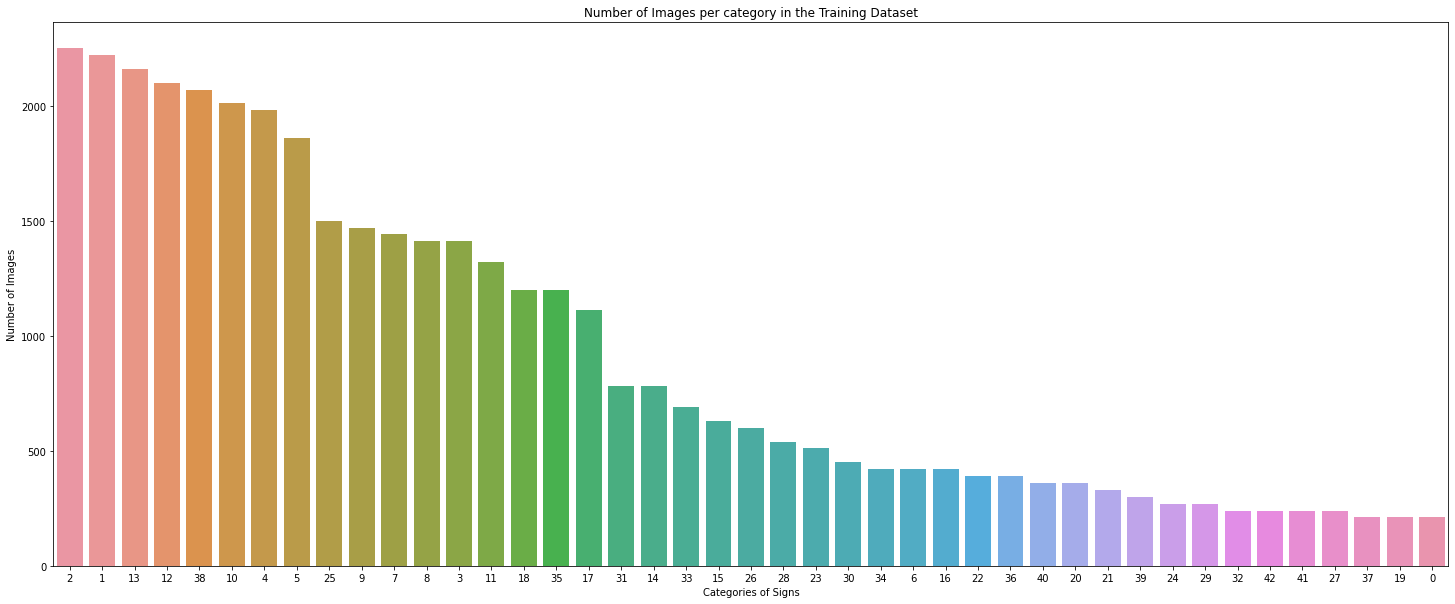

In [17]:
#plotting the number of samples in each class in train data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data = df_train, 
              x = 'ClassId',
              order = df_train['ClassId'].value_counts().index)
plt.xlabel('Categories of Signs')
plt.ylabel('Number of Images')
plt.title('Number of Images per category in the Training Dataset')
plt.savefig('/content/drive/MyDrive/Traffic_Sign_Recognition/train_images')
plt.show()

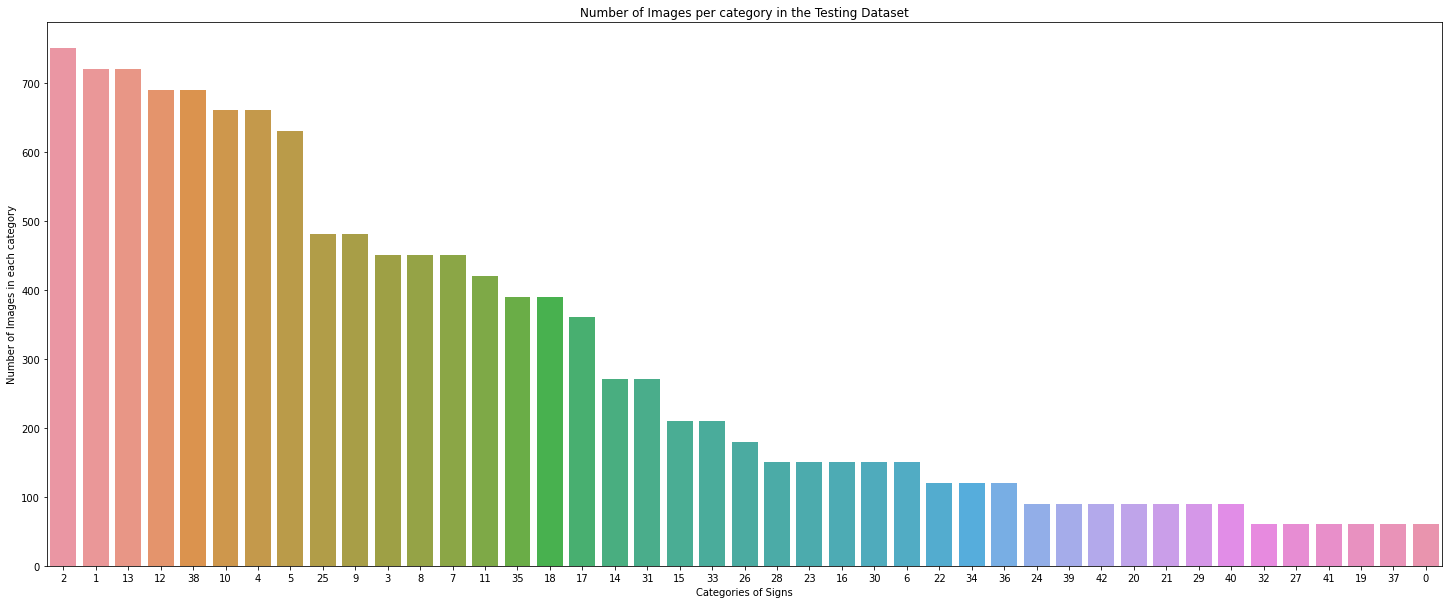

In [18]:
#plotting the number of samples in each class in test data
fig, ax = plt.subplots(1, 1)
fig.set_size_inches((25,10))
sns.countplot(data =df_test, 
              x = 'ClassId',
              order = df_test['ClassId'].value_counts().index)
plt.xlabel('Categories of Signs')
plt.ylabel('Number of Images in each category')
plt.title('Number of Images per category in the Testing Dataset')
plt.savefig('/content/drive/MyDrive/Traffic_Sign_Recognition/test_images')
plt.show()

We see that some categories like 2,1,13,12,38,10, 4,5 are having much more training/test samples as compared to 0,19,37,27

It is possible, that the categories which having less images are not used commonly, so their data is less


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


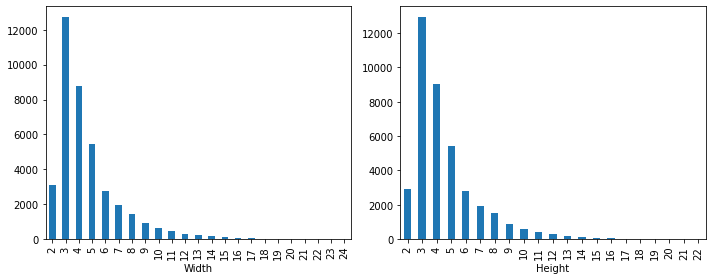

In [22]:
plt.figure(figsize = ( 10,4))
plt.subplot(1,2,1)
binned = df_train.Width.groupby(df_train.Width // 10).count()
binned.plot.bar()
plt.subplot(1,2,2)
binned = df_train.Height.groupby(df_train.Height // 10).count()
binned.plot.bar()
plt.tight_layout()
plt.show()

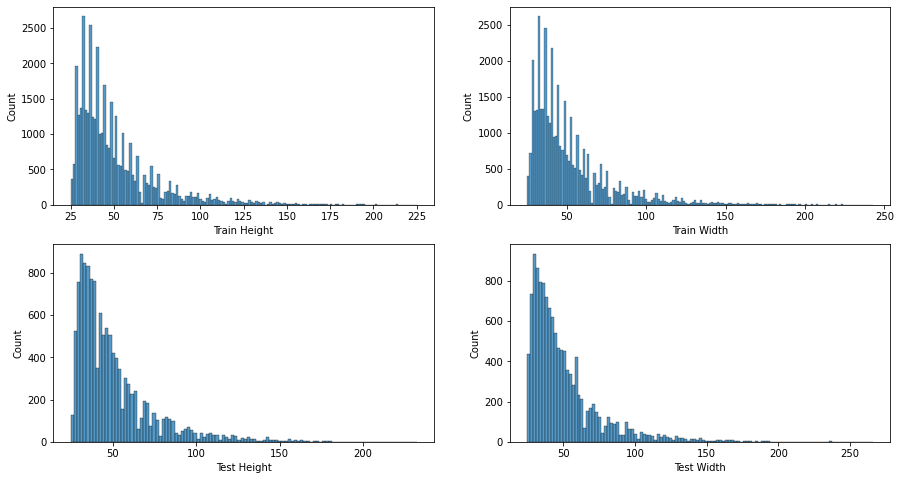

In [ ]:
#Distplot for Height and Width of images in train data
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((15,8))

sns.histplot(df_train['Height'], ax = ax[0][0])
ax[0][0].set_xlabel("Train Height")
sns.histplot(df_test['Height'], ax = ax[1][0])
ax[1][0].set_xlabel("Test Height")
sns.histplot(df_train['Width'], ax = ax[0][1])
ax[0][1].set_xlabel("Train Width")
sns.histplot(df_test['Width'], ax = ax[1][1])
ax[1][1].set_xlabel("Test Width")
plt.show()

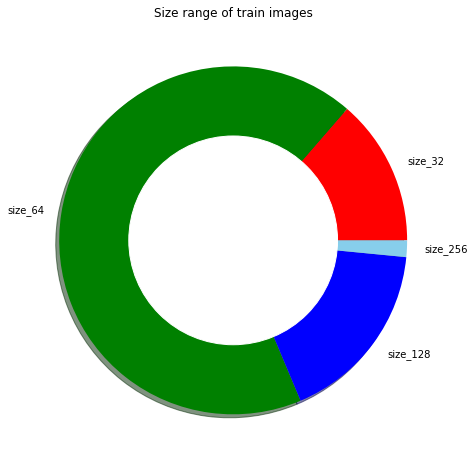

In [26]:
img_size_dict = {
    "size_32" : 0,
    "size_64" : 0,
    "size_128" : 0,
    "size_256" : 0,
    }
for index, row in df_train.iterrows():
  if (row[0] > 16 and row[1] > 16) and (row[0] < 32 and row[1] < 32) :
    img_size_dict['size_32'] += 1

  elif (row[0] > 32 and row[1] >= 32) and (row[0] < 64 and row[1] < 64) :
    img_size_dict['size_64'] += 1

  elif (row[0] > 64 and row[1] >= 64) and (row[0] < 128 and row[1] < 128) :
    img_size_dict['size_128'] += 1

  elif (row[0] > 128 and row[1] >= 128) and (row[0] < 256 and row[1] < 256) :
    img_size_dict['size_256'] += 1
#print(img_size_dict)
categories = list(img_size_dict.keys())
sizes = list(img_size_dict.values())


my_circle=plt.Circle( (0,0), 0.6, color='white')
fig = plt.figure(figsize=(8,8))
plt.pie(sizes, labels=categories, colors=['red','green','blue','skyblue'], shadow=True)
plt.title("Size range of train images")
p=plt.gcf()
p.gca().add_artist(my_circle)
fig.show()

We see that the number of images having size greater than 128 are very less. So all the images lesser than 128 will be padded with same pixels as the boundary and those with sizes greater than 128 will be cropped

21.713203463203463


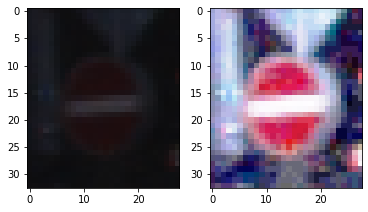

In [27]:
import numpy as np
from PIL import Image
im = Image.open('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/17/00017_00000_00000.png')

print(np.mean(im))

def enhance_image(image):
  # convert to grayscale
  imgray = image.convert()

  #convert to NumPy array
  img_array = np.asarray(image)
  
  # PERFORMING HISTOGRAM EQUALIZATION
  ##STEP 1: Normalized cumulative histogram
  #flatten image array and calculate histogram via binning
  histogram_array = np.bincount(img_array.flatten(), minlength=256)

  #normalize
  num_pixels = np.sum(histogram_array)
  histogram_array = histogram_array/num_pixels

  #normalized cumulative histogram
  chistogram_array = np.cumsum(histogram_array)

  ##STEP 2: Pixel mapping lookup table
  transform_map = np.floor(255 * chistogram_array).astype(np.uint8)

  ##STEP 3: Transformation
  # flatten image array into 1D list
  img_list = list(img_array.flatten())

  # transform pixel values to equalize
  eq_img_list = [transform_map[p] for p in img_list]

  # reshape and write back into img_array
  eq_img_array = np.reshape(np.asarray(eq_img_list), img_array.shape)

  # WRITING EQUALIZED IMAGE TO FILE
  #convert NumPy array to pillow Image and write to file
  eq_img = Image.fromarray(eq_img_array)
  
  return eq_img
plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(enhance_image(im))

plt.show()


In [ ]:
## Function to padd the images which are smaller than size (width/height)
def padding(image,size) :
  top, bottom, left, right = 0, 0, 0, 0
  if image.shape[0] < size :
    diff = size - image.shape[0]
    top = math.ceil(diff/2)
    bottom = math.floor(diff/2)
  if image.shape[1] < size :
    diff = size - image.shape[1]
    left = math.ceil(diff/2)
    right = math.floor(diff/2)
  image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_REPLICATE)
  return image

In [ ]:
## Function to truncate the image with size greater than 128(width/height)
def truncate(image,size) :
  #print(image.shape)
  #plt.imshow(image)
  x1,y1,x2,y2 = 0,0,image.shape[0],image.shape[1]
  w = math.ceil(image.shape[0]/2)
  h = math.ceil(image.shape[1]/2)
  #print(w,h)
  if image.shape[0] > size :
    x1 = int(w - size/2)
    x2 = int(w + size/2)
  if image.shape[1] > size :
    y1 = int(h - size/2)
    y2 = int(h + size/2)
  #print(x1,x2,y1,y2)
  image = image[x1:x2, y1:y2]
  return image
# image = cv2.imread('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/0/00000_00005_00029.png')
# print(image.shape)
# plt.subplot(1,3,1)
# plt.imshow(image)
# image = truncate(image,64)
# print(image.shape)
# plt.subplot(1,3,2)
# plt.imshow(image)
# image = Image.fromarray(image)
# image = enhance_image(image)
# plt.subplot(1,3,3)
# plt.imshow(image)

(33, 26, 3)


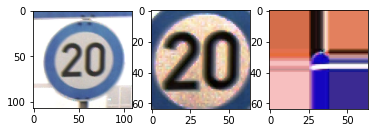

In [ ]:
import math
image = cv2.imread('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/17/00017_00000_00006.png')
#image = cv2.imread('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/20/00020_00000_00000.png')
image1 = image[5:22, 5:20]
print(image.shape)
image = cv2.imread('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/0/00000_00005_00029.png')

def preprocess_image(image,size):
  '''
  This function takes an image and crops/pads it to the given size
  It also enhances the images so that image quality is better
  '''
  image = padding(image,size)       # padding if image is smaller than given size
  image = truncate(image,size)      # cropping if image is bigger than given size
  image = Image.fromarray(image)
  image = enhance_image(image)      # image enhancement
  return image
#print(image1)
#data.append(np.array(image))

plt.subplot(1,3,1)
plt.imshow(image)
plt.subplot(1,3,2)
plt.imshow(preprocess_image(image,64))
plt.subplot(1,3,3)
plt.imshow(preprocess_image(image1,64))
plt.show()

In [ ]:
Class = os.listdir('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/0') 
for c in Class:
  image = cv2.imread(c)
c

'00000_00003_00026.png'

In [ ]:
# adding a column for image name in df_train created from csv file
df_train['image_name'] =  df_train.Path.apply(lambda x: pd.Series(str(x).split("/")[2] ) )

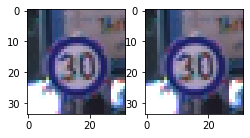

In [ ]:
# image_name = 'Train/20/00020_00000_00000.png'
# df_train = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train.csv')

c = '00000_00003_00026.png'
path = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/0/'
def get_bb_image(image_name,path):
  image = cv2.imread(path + image_name)
  x = df_train[df_train.image_name == image_name]
  if len(x)>0:
    x1,y1,x2,y2 = x.iloc[0]['Roi.X1'],x.iloc[0]['Roi.Y1'],x.iloc[0]['Roi.X2'],x.iloc[0]['Roi.Y2']
    image = image[x1:x2][y1:y2]
  
  return image
path = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/1/'
c = '00001_00005_00006 (1).png'
image =   get_bb_image(c,path)
s = path +c
im1 = cv2.imread(s)
plt.subplot(1,3,1)
plt.imshow(im1)
plt.subplot(1,3,2)
plt.imshow(get_bb_image(c,path))



In [ ]:
#Function to load each image with same dimensions
from tqdm import tqdm
def load_train_images_preprocessed() :

  n_classes = 43
  data = []
  labels = []

  #Reading the train images
  for itr in range(n_classes):
    path = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/{0}/'.format(itr)
    Class = os.listdir(path)       # list of names of all files in a folder
    Class = sorted(Class)
    for c in Class :               # iterating over each image name  in that folder
      ## print(path+c)
      image = cv2.imread(path + c) # capturing the image 
      image = get_bb_image(c,path)
      image = preprocess_image(image,64)
      data.append(np.array(image))
      labels.append(itr)
    
    np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/data_cropped',data)
    np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/labels_cropped',labels)  
    print('Total Images processed for class',itr,'are',len(Class)) 

  data=np.array(data)
  labels=np.array(labels)
  return data, labels

In [ ]:
%%time
data_cropped,labels_cropped = load_train_images_preprocessed()
np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/data_cropped',data_cropped)
np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/labels_cropped',labels_cropped)


Total Images processed for class 0 are 210
Total Images processed for class 1 are 2232
Total Images processed for class 2 are 2250
Total Images processed for class 3 are 1410
Total Images processed for class 4 are 1980
Total Images processed for class 5 are 1860
Total Images processed for class 6 are 440
Total Images processed for class 7 are 1440
Total Images processed for class 8 are 1410
Total Images processed for class 9 are 1470
Total Images processed for class 10 are 2010
Total Images processed for class 11 are 1320
Total Images processed for class 12 are 2100
Total Images processed for class 13 are 2160
Total Images processed for class 14 are 780
Total Images processed for class 15 are 630
Total Images processed for class 16 are 420
Total Images processed for class 17 are 1110
Total Images processed for class 18 are 1200
Total Images processed for class 19 are 210
Total Images processed for class 20 are 360
Total Images processed for class 21 are 330
Total Images processed for c

In [ ]:
dfadhgn ;

In [ ]:
 plt.figure(figsize=(30,30))
for i in range(len(data)):
  plt.subplot(10,21,1+i)
  plt.imshow(data[i])


In [ ]:
# plot for cropped images as per the bb given
plt.figure(figsize=(30,30))
for i in range(len(data_cropped)):
  plt.subplot(10,21,1+i)
  plt.imshow(data[i])

In [ ]:
path = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Train/0/'

plt.figure(figsize=(30,30))
for i in range(len(Class)):
  img = path + Class[i]
  img = cv2.imread(img)
  plt.subplot(10,21,1+i)
  plt.imshow(img)



In [ ]:
plt.imshow(data[13])

In [ ]:
%%time
#Loading the preprocessed images(it takes 2:34 hours to process it. So the files have been saved and will be used in future)
# import random
# import math
# data_preprocessed, new_labels = load_train_images_preprocessed()
# np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/data_preprocessed',data_preprocessed)
# np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/labels',labels)


In [ ]:
data_preprocessed = np.load('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/data_cropped.npy')
image_labels = np.load('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/labels_cropped.npy')
print(data_preprocessed.shape,image_labels.shape)

(39251, 64, 64, 3) (39251,)


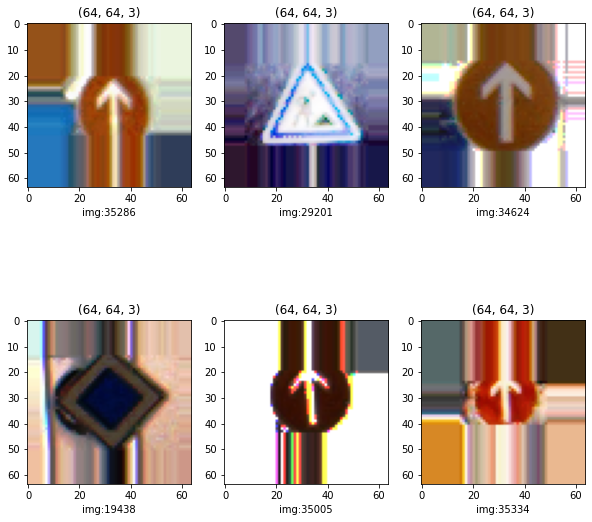

In [ ]:
#randomly plotting the preprocessed images
import random
fig, ax = plt.subplots(2,3)
height, width = 10, 10
for i in range(2):
  for j in range(3):

    fig.set_size_inches(height, width)
    seed = random.randrange(0, data_preprocessed.shape[0])
    ax[i][j].title.set_text(data_preprocessed[seed].shape)
    ax[i][j].imshow(data_preprocessed[seed])
    ax[i][j].set_xlabel("img:"+ str(seed))
    


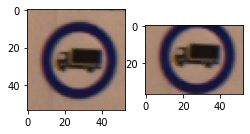

In [ ]:

def get_bb_image_test(image_name,path):
  image = cv2.imread(path + image_name)
  x = test[test.Path == 'Test/'+image_name]
  if len(x)>0:
    
    x1,y1,x2,y2 = x.iloc[0]['Roi.X1'],x.iloc[0]['Roi.Y1'],x.iloc[0]['Roi.X2'],x.iloc[0]['Roi.Y2']
    image = image[x1:x2][y1:y2]
    #print(x1,x2,y1,y2)
  return image
path = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Test/'
c = '00000.png'
image =   get_bb_image_test(c,path)
s = path +c
im1 = cv2.imread(s)
plt.subplot(1,3,1)
plt.imshow(im1)
plt.subplot(1,3,2)
plt.imshow(get_bb_image_test(c,path))

In [ ]:
# adding a column for image name in df_train created from csv file
test = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Test.csv')
# data_dir = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign'
#test['image_name'] =  test.Path.apply(lambda x: pd.Series(str(x).split("/")[1] ) )

In [ ]:
test.head(3)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png


In [ ]:
# processing test data for future use
#test = pd.read_csv('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Test.csv')
data_dir = '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign'
labels = test["ClassId"].values
np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/test_labels_cropped',labels) 
imgs = test["Path"].values
IMG_HEIGHT, IMG_WIDTH = 64,64
data =[]
path =  '/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/Test/'
for img in imgs:
  c = str(img).split('/')[1]

  image = cv2.imread(path + c) # capturing the image 
  #print(path+c)
  image = get_bb_image_test(c,path)
  image = preprocess_image(image,64)
  data.append(np.array(image))
  
np.save('/content/drive/MyDrive/Traffic_Sign_Recognition/data_traffic_sign/test_data_cropped',data)
